# Section 3: Embedding

## Word Embedding on Hamshahri Newspaper dataset

In this section, we want to try different Word Embedding methods. We work on the Hamshahri dataset that is preprocessed in the previous notebook.(Text_Classification.ipynb)

In the beginning, we load the dataset and take a look at the length of texts in it. Then we create an LSTM model for it because based on our result, LSTM models are good for text classification and sentiment analysis. Then try to print word embedding for a few words from the embedding layer in our model and try other embedding methods(e.g. Gensim and Fasttext)

In [1]:
!pip install parsivar
!pip install python-bidi
!pip install arabic-reshaper

In [2]:
# Loading NLTk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# NLP libraries
import parsivar
from parsivar import Normalizer, Tokenizer, FindStems, POSTagger, FindChunks

# plot
import matplotlib.pyplot as plt

import pandas as pd
import string
import re
import numpy as np
np.random.seed(0)

# libraries for show persian words in correct way(right to left)
from bidi.algorithm import get_display
from arabic_reshaper import reshape

import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read dataset

In [ ]:
#load the preprocessing dataframe
ham_train = pd.read_csv('/content/drive/MyDrive/AI-Internship/preprocessed_data/train.csv')
ham_valid = pd.read_csv('/content/drive/MyDrive/AI-Internship/preprocessed_data/valid.csv')
ham_test = pd.read_csv('/content/drive/MyDrive/AI-Internship/preprocessed_data/test.csv')

In [ ]:
print(f'ham train shape: {ham_train.shape}')
print(f'ham valid shape: {ham_valid.shape}')
print(f'ham test shape: {ham_test.shape}')

ham train shape: (8724, 2)
ham valid shape: (2181, 2)
ham test shape: (2727, 2)


In [ ]:
ham_train.head()

,preprocessing_text,label
0,مخبر کمیسیون امنیت ملی سیاست خارجی مجلس نسبت ا...,3
1,علی تاجرنیا نماینده مشهد مجلس انتقاد محاکمه سی...,3
2,عضو کمیسیون صنایع معادن مجلس شورا اسلامی منظور...,2
3,دریابان علی شمخانی وزیر دفاع جمهوری اسلامی ایر...,3
4,گردهمایی کارشناس کارکنان سازمان دانش آموخت&آمو...,4


label encoding (based on lexical order):

    سیاسی -> 3
    اقتصاد -> 2
    اجتماعی-> 0
    ورزش -> 5
    علمی فرهنگی -> 4
    ادب و هنر -> 1


In [ ]:
ham_train.label.value_counts()

3    2086
2    1917
5    1379
0    1350
4    1253
1     739
Name: label, dtype: int64

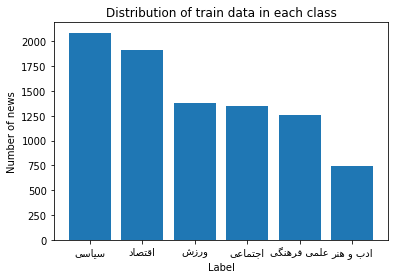

In [ ]:
# destribution of data in each class
distribution  = list(ham_train.label.value_counts())

classes = ['سیاسی','اقتصاد','ورزش','اجتماعی','علمی فرهنگی','ادب و هنر'] 
classes = [get_display(reshape(label)) for label in classes]

plt.bar(classes, distribution)
plt.xlabel("Label")
plt.ylabel("Number of news")
plt.title("Distribution of train data in each class")
plt.show()

In [ ]:
ham_valid.label.value_counts()

2    519
3    511
5    332
0    323
4    312
1    184
Name: label, dtype: int64

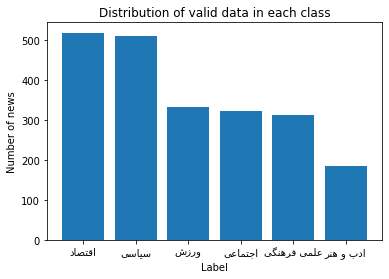

In [ ]:
# destribution of data in each class
distribution  = list(ham_valid.label.value_counts())

classes = ['اقتصاد','سیاسی','ورزش','اجتماعی','علمی فرهنگی','ادب و هنر'] 
classes = [get_display(reshape(label)) for label in classes]

plt.bar(classes, distribution)
plt.xlabel("Label")
plt.ylabel("Number of news")
plt.title("Distribution of valid data in each class")
plt.show()

In [ ]:
ham_test.label.value_counts()

3    622
2    598
0    462
4    404
5    402
1    239
Name: label, dtype: int64

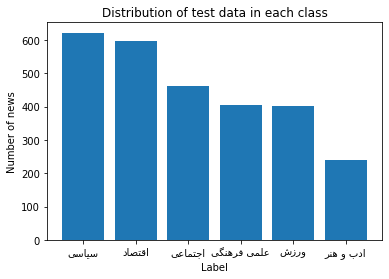

In [ ]:
# destribution of data in each class
distribution  = list(ham_test.label.value_counts())

classes = ['سیاسی','اقتصاد','اجتماعی','علمی فرهنگی', 'ورزش','ادب و هنر'] 
classes = [get_display(reshape(label)) for label in classes]

plt.bar(classes, distribution)
plt.xlabel("Label")
plt.ylabel("Number of news")
plt.title("Distribution of test data in each class")
plt.show()

As we see in the following cell, we have on missing value in our text column, So in order to calculate text length, we should drop this row.

In [ ]:
ham_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8724 entries, 0 to 8723
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   preprocessing_text  8723 non-null   object
 1   label               8724 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 136.4+ KB


In [ ]:
df = ham_train.copy()
ham_train = df.dropna()

In [ ]:
ham_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8723 entries, 0 to 8723
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   preprocessing_text  8723 non-null   object
 1   label               8723 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 204.4+ KB


In [ ]:
# ham_train.to_csv('/content/drive/MyDrive/AI-Internship/preprocessed_data/train_updated.csv', index=False)

Let's take a look at length of texts in dataset.

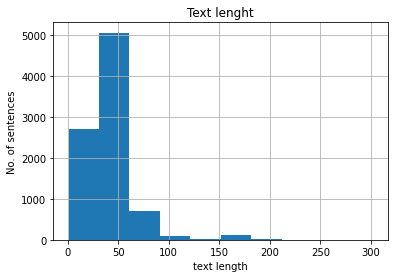

count    8723.000000
mean       42.027743
std        22.978069
min         1.000000
25%        29.000000
50%        38.000000
75%        48.000000
max       302.000000
dtype: float64

In [ ]:
text_len = [len(i.split()) for i in ham_train.preprocessing_text.values]
pd.Series(text_len).hist()
plt.title('Text lenght')
plt.xlabel('text length')
plt.ylabel('No. of sentences')
plt.show()
pd.Series(text_len).describe()

### Prepare Dataset for Neural Network

In [5]:
import torch
import torchtext
from torchtext.legacy import data
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.optim import lr_scheduler
from torch.utils.data.dataset import random_split

from sklearn.metrics import classification_report
from torchtext.vocab import Vectors
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

#Reproducing same results
SEED = 2019
torch.manual_seed(SEED)

#### Load the custom dataset using PyTorchText TabularDataset

In [6]:
# define pipline for text and label columns
TEXT = data.Field(tokenize='spacy',
                  include_lengths=True, batch_first=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

In [7]:
fields = [('preprocessing_text',TEXT), ('label', LABEL)]

In [8]:
train_data = data.TabularDataset(path='/content/drive/MyDrive/AI-Internship/preprocessed_data/train_updated.csv'
                                , format='csv', fields=fields, skip_header=True)

valid_data = data.TabularDataset(path='/content/drive/MyDrive/AI-Internship/preprocessed_data/valid.csv'
                                , format='csv', fields=fields, skip_header=True)

test_data = data.TabularDataset(path='/content/drive/MyDrive/AI-Internship/preprocessed_data/test.csv'
                                , format='csv', fields=fields, skip_header=True)


In [9]:
len(train_data)

8723

#### Construct Vocabulary

In [9]:
TEXT.build_vocab(train_data, valid_data,min_freq=3 )
LABEL.build_vocab(train_data, valid_data)

In [ ]:
#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))
print("Size of TEXT vocabulary:",len(LABEL.vocab))
print(" ")
print('-'*200)

#Commonly used words
print(f'10 commonly used words : {TEXT.vocab.freqs.most_common(10)}')  
print(" ")
print('-'*200)

#Word dictionary
print(f'word dictionary : {TEXT.vocab.stoi}') 

Size of TEXT vocabulary: 9802
Size of TEXT vocabulary: 6
 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
10 commonly used words : [('ایران', 6568), ('کشور', 5182), ('اسلامی', 4086), ('سال', 3229), ('تهران', 3182), ('رئیس', 2631), ('شورا', 2613), ('تیم', 2487), ('جمهوری', 2458), ('گزارش', 2203)]
 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
word dictionary : defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f3be4db5390>>, {'<unk>': 0, '<pad>': 1, 'ایران': 2, 'کشور': 3, 'اسلامی': 4, 'سال': 5, 'تهران': 6, 'رئیس': 7, 'شورا': 8, 'تیم': 9, 'جمهوری': 10, 'گزارش': 11, 'سازمان': 12, 'مجلس': 13, 'ملی': 14, 'شرکت': 15, 'شهر': 16, 'سرمایه\u200cگ

In [10]:
vocab_size = len(TEXT.vocab)
batch_size = 8
embed_dim = 128
num_class = 6

print(f'vocab size : {vocab_size}')

vocab size : 9802


In the following cell, we check that which device we are using. Then we should migrate our variables and models on it.

https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [12]:
# create dataloader
train_loader = data.BucketIterator(train_data, batch_size, sort_key= lambda x: len(x.preprocessing_text),
                                  train=True, shuffle=True, sort_within_batch=True, device=device)

valid_loader = data.BucketIterator(valid_data, batch_size, sort_key= lambda x: len(x.preprocessing_text),
                                  train=False, shuffle=False, sort_within_batch=True, device=device)

test_loader = data.BucketIterator(test_data, batch_size, sort_key= lambda x: len(x.preprocessing_text),
                                  train=False, shuffle=False, sort_within_batch=True, device=device)


In [14]:
print(f'length of train_dataset is : {len(train_data)} and length of train_loader is : {len(train_loader)}')
print(f'length of valid_dataset is : {len(valid_data)} and length of valid_loader is : {len(valid_loader)}')
print(f'length of test_dataset is : {len(test_data)} and length of test_loader is : {len(test_loader)}')

length of train_dataset is : 8723 and length of train_loader is : 1091
length of valid_dataset is : 2181 and length of valid_loader is : 273
length of test_dataset is : 2727 and length of test_loader is : 341


Let's take a look at one batch of train_loader.


In [ ]:
for batches in train_loader:
  print(f'batch size : {len(batches)}')
  print(batches)
  x, y = batches.preprocessing_text
  print(f'text : {x}')
  print(f'text shape : {x.shape}')
  print(f'len(text) : {len(x)}')
  print(f'text length : {y}')
  print(f'label : {batches.label}')
  break

batch size : 8

[torchtext.legacy.data.batch.Batch of size 8]
	[.preprocessing_text]:('[torch.LongTensor of size 8x29]', '[torch.LongTensor of size 8]')
	[.label]:[torch.FloatTensor of size 8]
text : tensor([[ 584,   40,   10,    4,  152, 1013,   72, 7841, 1480,  152, 1013,  303,
         7841,  187,  282,  173, 3584, 1794, 2072,   16,  584, 1299, 1902, 1231,
         4473,  271,  323, 1096,  270],
        [   8,  802,  822,  114,  802,  157,  226,  650,  138, 1612,  802,    6,
          994,  802, 4250, 1125,  822,    8,  802,    0,  313,    8,  802,  822,
          114,  802,  157,  226,  650],
        [ 526,  347,   76, 2108,  538,    2,  636,  429,    5,  925,   82,  124,
            5,   82,   77,   11,   12,  428, 1207,  636,  429,  543,    2,    5,
           82,  124,    5,   58, 8564],
        [7836,    0,    7,   10, 2471,  675, 2100,  799,   36,    6, 4876, 2471,
         6315,  726,  194,  122,    7,   10,    2,    3,  951,  427, 1145,  853,
          122,  194, 2471,  434,

### Building model

**When we define class for LSTM model or CNN model, we should not pass (model_class_name, self) to super. It give us an error when we want to load model.**

In [ ]:
class LSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
               num_layers, dropout ):
    super().__init__()
    
    #embedding layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    
    #lstm layer
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)

    #dense layer
    self.fc = nn.Linear(hidden_dim*2, output_dim)

  def forward(self, text, text_lengths):
    # text = [batch size, sent_len}
    embedded = self.embedding(text)
    # embedded = [batch_size, sent_len, emd dim]

    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)

    packed_out, (hidden, cell) = self.lstm(packed_embedded)
    #hidden = [batch size, num layers * num directions,hid dim]
    #cell = [batch size, num layers * num directions,hid dim]

    # concat the final forward and backward hidden state
    hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

    # hidden = [batch size, hid dim* num direction]
    outputs = self.fc(hidden)

    
    return outputs


In [ ]:
# define hyperparameters
vocab_size = len(TEXT.vocab)
embedding_dim = 128
num_hidden_nodes = 32
num_output_nodes = 6
num_layers = 2
dropout = 0.3

model1 = LSTM(vocab_size, embedding_dim, num_hidden_nodes, 
                           num_output_nodes, num_layers, dropout=dropout)

In [ ]:
print(model1)

LSTM(
  (embedding): Embedding(9802, 128)
  (lstm): LSTM(128, 32, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [ ]:
num_epoch = 10
learning_rate= 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, 2, gamma=0.7)


n_total_step = len(train_loader)

In [ ]:
# Define a funciton to calculate accuracy for multi class classification model
def multi_class_acc(y_pred, y_act):

  y_pred_softmax = torch.softmax(y_pred, 1)
  _, y_pred_tag = torch.max(y_pred_softmax,1)

  correct = (y_pred_tag == y_act).float()  # Show which elements are the same with 1
  acc = correct.sum()/len(correct)
  acc = torch.round(acc * 100)

  return acc

### Train and Evaluate the model

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('model_Ham')

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir 'model_Ham'

In [ ]:
# define a function for training a model
def train(model1, train_loader):
  
  train_epoch_loss = 0
  train_epoch_acc = 0
  
  # train the model
  model1.train()

  loop = tqdm(enumerate(train_loader), total = n_total_step, leave = False)

  for i, batch in loop:
    
    optimizer.zero_grad()

    # retrieve text and number of words
    text, text_lengths = batch.preprocessing_text

    # convert to 1D tensor
    y_pred = model1(text, text_lengths).squeeze()

    # because our labels in form of float tensor, we should convert them to long tensor(int)
    label = batch.label.to(torch.long)

    loss_train = criterion(y_pred, label)

    acc_train = multi_class_acc(y_pred, label)

    loss_train.backward()

    optimizer.step()

    train_epoch_loss += loss_train.item()
    train_epoch_acc += acc_train.item()

    loop.set_description(f'Epoch : [{epoch}/{num_epoch}]')
    loop.set_postfix(loss = loss_train.item(), accuracy = acc_train.item()) 
  
  train_loss.append(train_epoch_loss/len(train_loader))
  train_acc.append(train_epoch_acc/len(train_loader))  
      
  # if you want to monitor your model in tensorboard   
  writer.add_scalar('training loss',train_epoch_loss/len(train_loader) , epoch)
  writer.add_scalar('training accuracy',train_epoch_acc/len(train_loader) , epoch)

  return train_loss, train_acc


# define a function for evaluating model
def evaluate(model1, valid_loader):

  # validation
  with torch.no_grad():
    model1.eval()

    val_epoch_loss = 0
    val_epoch_acc = 0

    for batch in valid_loader:

      text, text_length = batch.preprocessing_text

      y_pred_val = model1(text, text_length).squeeze()
      label = batch.label.to(torch.long)
      loss_valid = criterion(y_pred_val, label)
      acc_valid =  multi_class_acc(y_pred_val, label) 

      val_epoch_loss += loss_valid.item()
      val_epoch_acc += acc_valid.item()

    valid_loss.append(val_epoch_loss/len(valid_loader))
    valid_acc.append(val_epoch_acc/len(valid_loader))  

  return valid_loss, valid_acc


In [ ]:
!nvidia-smi

Sun Sep  5 05:15:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    31W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tqdm import tqdm

train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

for epoch in range(num_epoch):

  train_loss, train_acc = train(model1, train_loader)
  writer.flush() 
  valid_loss, valid_acc = evaluate(model1, valid_loader)   

  scheduler.step()

In [ ]:
torch.save(model1, '/content/drive/MyDrive/AI-Internship/model1LSTM_hamshahri') # model1 with 10 epochs

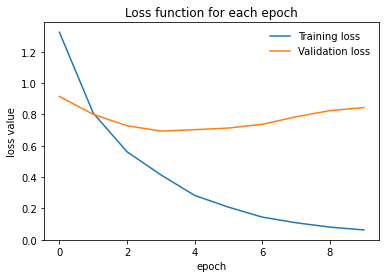

In [ ]:
#Training and validation loss
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.title("Loss function for each epoch") 
plt.show()

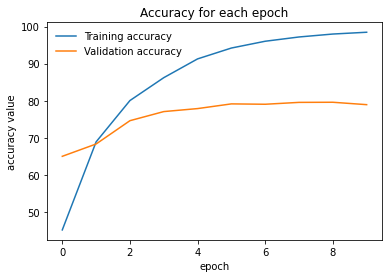

In [ ]:
#Training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('accuracy value')
plt.title("Accuracy for each epoch")
plt.show()

In [ ]:
scheduler.state_dict()

{'_get_lr_called_within_step': False,
 '_last_lr': [0.00016806999999999998],
 '_step_count': 11,
 'base_lrs': [0.001],
 'gamma': 0.7,
 'last_epoch': 10,
 'step_size': 2,
 'verbose': False}

In [ ]:
model1.state_dict

<bound method Module.state_dict of LSTM(
  (embedding): Embedding(9802, 128)
  (lstm): LSTM(128, 32, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)>

In [ ]:
print(f'training loss on last epoch : {train_loss[-1]}')
print(f'validation loss on last epoch : {valid_loss[-1]}')
print('-'*20)
print(f'training accuracy on last epoch : {train_acc[-1]}')
print(f'validation accuracy on last epoch : {valid_acc[-1]}')

training loss on last epoch : 0.0623618938352876
validation loss on last epoch : 0.844019867832885
--------------------
training accuracy on last epoch : 98.45737855178736
validation accuracy on last epoch : 78.92673992673993


### Test the model

In [ ]:
classes = ['اجتماعی', 'ادب و هنر', 'اقتصاد', 'سیاسی', 'علمی فرهنگی', 'ورزش']

In [ ]:
def test(model1, test_loader):
  y_pred_test = []
  y_actual_test = []

  model1.eval()
  with torch.no_grad():
    n_true = 0
    n_total = 0
    n_class_correct = [0 for i in range(num_class)]
    n_class_sample = [0 for i in range(num_class)]
  
    for batch in test_loader:

      text, text_length = batch.preprocessing_text

      output = model1(text, text_length).squeeze()

      _, y_predtest = torch.max(output,1)

      n_true += (y_predtest == batch.label).sum()
      n_total += batch.label.size(0)

      for i in range(len(y_predtest)):
        y_pred_test.append(y_predtest[i])
        y_actual_test.append(batch.label[i].item())

      for i in range(len(y_predtest)):
        lb = int(batch.label[i].item())
        pred = y_predtest[i]
        if pred == lb:
          n_class_correct[lb] += 1
        n_class_sample[lb] += 1   

    print(f'accuracy of network on the {len(test_loader)} texts is : {(n_true/n_total) *100}')
  
    for i in range(len(classes)):
      acc = 100.0 * n_class_correct[i] / n_class_sample[i]
      print(f'Accuracy of {classes[i]}: {acc} %')
  
  return y_pred_test, y_actual_test

In [ ]:
y_pred_test, y_actual_test = test(model1, test_loader)

accuracy of network on the 341 texts is : 78.98789978027344
Accuracy of اجتماعی: 81.35048231511254 %
Accuracy of ادب و هنر: 87.62541806020067 %
Accuracy of اقتصاد: 94.27860696517413 %
Accuracy of سیاسی: 61.47186147186147 %
Accuracy of علمی فرهنگی: 72.27722772277228 %
Accuracy of ورزش: 70.7112970711297 %


### Confusion Matrix

In [ ]:
# libraries for show persian words in correct way(right to left)
from bidi.algorithm import get_display
from arabic_reshaper import reshape

def confusion_matrix(y_actual_test, y_pred_test):
  
  plt.figure(figsize = (10,7))
  ax= plt.subplot()
  cnf_matrix = metrics.confusion_matrix(y_actual_test, y_pred_test)
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
  ax.set_title('Confusion Matrix of model 1'); 
  class_names= classes
  # set persian names in correct way
  class_names = [get_display(reshape(label)) for label in class_names]
  ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);
  plt.tight_layout()

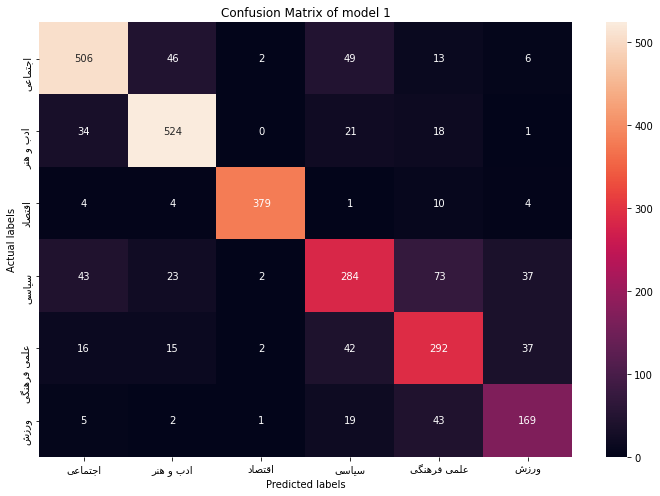

In [ ]:
confusion_matrix(y_actual_test, y_pred_test)

In [ ]:
print(classification_report(y_actual_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82       622
         1.0       0.85      0.88      0.86       598
         2.0       0.98      0.94      0.96       402
         3.0       0.68      0.61      0.65       462
         4.0       0.65      0.72      0.68       404
         5.0       0.67      0.71      0.69       239

    accuracy                           0.79      2727
   macro avg       0.78      0.78      0.78      2727
weighted avg       0.79      0.79      0.79      2727



## Get word vector from Embedding layer

**Before load the model, we should run the cell that our class of model in it. If we don't do it, it gives us error.**

In [ ]:
model1 = torch.load('/content/drive/MyDrive/AI-Internship/model1LSTM_hamshahri')

In [ ]:
print(model1)

LSTM(
  (embedding): Embedding(9802, 128)
  (lstm): LSTM(128, 32, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [ ]:
boy =  TEXT.vocab.stoi['پسر']
child = TEXT.vocab.stoi['کودک']
fish = TEXT.vocab.stoi['ماهی']

print(f'index of boy : {boy}, index of child : {child}, index of fish : {fish}')

boy_embed = model1.embedding(torch.tensor(boy))
child_embed = model1.embedding(torch.tensor(child))
fish_embed = model1.embedding(torch.tensor(fish))

index of boy : 1139, index of child : 143, index of fish : 2107


In [ ]:
print(f'boy_embed shape: {boy_embed.shape}')
print(f'child_embed shape : {child_embed.shape}')
print(f'fish_embed shape : {fish_embed.shape}')

boy_embed shape: torch.Size([128])
child_embed shape : torch.Size([128])
fish_embed shape : torch.Size([128])


In [ ]:
boy_embed

tensor([-1.8142, -0.7879, -0.9591,  0.8549,  1.0381,  1.8010,  2.5400, -2.1065,
        -1.8167,  0.3648,  0.3850, -0.2662, -0.4410,  0.8093, -0.2465, -1.6679,
         0.0740, -0.2081,  0.1731,  0.7464,  0.5341, -0.7943,  0.6945, -0.5339,
         0.3576,  0.3231,  0.2664,  0.4831, -1.1682,  1.1127,  0.9054,  1.1607,
        -0.9642,  0.7982,  1.2884, -0.1596,  0.7608,  1.5504,  1.1328, -1.2832,
        -0.4766,  0.6810, -1.2899, -0.9407,  0.0349, -0.6688,  0.6697,  0.1013,
        -1.0894, -0.0245, -0.9701,  0.1136, -1.1523,  1.4279, -0.0913,  0.8113,
         0.0669,  0.8797,  1.1270,  2.0819,  0.3517,  2.2403,  1.1120,  1.5252,
         0.3403, -1.1239,  0.9155,  0.9142,  0.5975, -1.3170,  0.8972,  0.8846,
         0.3901,  0.4965, -1.2770,  1.3922, -0.8238, -1.8485, -1.7148,  1.3693,
        -0.1443,  0.4313,  0.6515,  1.5532, -0.0179, -0.1966,  1.3597, -0.4126,
         1.2492, -0.3331,  0.0112,  1.7747, -1.0775,  0.3730, -0.6187,  0.6480,
        -0.2482, -0.5701,  1.4460,  0.62

In [ ]:
print(model1.embedding.weight[1139])

tensor([-1.8142, -0.7879, -0.9591,  0.8549,  1.0381,  1.8010,  2.5400, -2.1065,
        -1.8167,  0.3648,  0.3850, -0.2662, -0.4410,  0.8093, -0.2465, -1.6679,
         0.0740, -0.2081,  0.1731,  0.7464,  0.5341, -0.7943,  0.6945, -0.5339,
         0.3576,  0.3231,  0.2664,  0.4831, -1.1682,  1.1127,  0.9054,  1.1607,
        -0.9642,  0.7982,  1.2884, -0.1596,  0.7608,  1.5504,  1.1328, -1.2832,
        -0.4766,  0.6810, -1.2899, -0.9407,  0.0349, -0.6688,  0.6697,  0.1013,
        -1.0894, -0.0245, -0.9701,  0.1136, -1.1523,  1.4279, -0.0913,  0.8113,
         0.0669,  0.8797,  1.1270,  2.0819,  0.3517,  2.2403,  1.1120,  1.5252,
         0.3403, -1.1239,  0.9155,  0.9142,  0.5975, -1.3170,  0.8972,  0.8846,
         0.3901,  0.4965, -1.2770,  1.3922, -0.8238, -1.8485, -1.7148,  1.3693,
        -0.1443,  0.4313,  0.6515,  1.5532, -0.0179, -0.1966,  1.3597, -0.4126,
         1.2492, -0.3331,  0.0112,  1.7747, -1.0775,  0.3730, -0.6187,  0.6480,
        -0.2482, -0.5701,  1.4460,  0.62

As we see, in previous cell, when we want to get word vector from embedding layer, we can use model.embedding(tensor of index of word) or model.embedding.weight[index of word]

In [ ]:
similarity_boy_child = torch.dot(boy_embed, child_embed)
similarity_boy_fish = torch.dot(fish_embed, boy_embed)

print(f'similarity of boy and child : {similarity_boy_child}')
print(f'similarity of boy and fish : {similarity_boy_fish}')

similarity of boy and child : 0.6667170524597168
similarity of boy and fish : -3.3541207313537598


As we see in the above cell, dot product of boy and child is greater than dot product of fish and child. It means boy and child have more similarity than fish and child.

## Word Embedding with Gensim

### Gensim Tutorial

#### Usage examples

https://radimrehurek.com/gensim/models/word2vec.html

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [14]:
# !pip uninstall numpy
# !pip install numpy

Found existing installation: numpy 1.19.5
Uninstalling numpy-1.19.5:
  Would remove:
    /usr/bin/f2py
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.7
    /usr/local/lib/python3.7/dist-packages/numpy-1.19.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libgfortran-2e0d59d6.so.5.0.0
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libopenblasp-r0-09e95953.3.13.so
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libquadmath-2d0c479f.so.0.0.0
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/numpy/*
Proceed (y/n)? y
  Successfully uninstalled numpy-1.19.5
     |████████████████████████████████| 15.7 MB 161 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is inco

In [7]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [8]:
import os

# we use os.linesep for linebreaker
print(common_texts, os.linesep)
print(f'length of common texts : {len(common_texts)}')

[['human', 'interface', 'computer'], ['survey', 'user', 'computer', 'system', 'response', 'time'], ['eps', 'user', 'interface', 'system'], ['system', 'human', 'system', 'eps'], ['user', 'response', 'time'], ['trees'], ['graph', 'trees'], ['graph', 'minors', 'trees'], ['graph', 'minors', 'survey']] 

length of common texts : 9


In [ ]:
# !mkdir -p /content/drive/MyDrive/AI-Internship/HamModels

In [ ]:
model = Word2Vec(sentences=common_texts, size=100, window=5, 
                 min_count=1, workers=4)
model.save('/content/drive/MyDrive/AI-Internship/HamModels/word2vec.model')

In [ ]:
print(model)

Word2Vec(vocab=12, size=100, alpha=0.025)


Let's continue training model with other words.

In [ ]:
model = Word2Vec.load('/content/drive/MyDrive/AI-Internship/HamModels/word2vec.model')

# Update the model's neural weights from a sequence of sentences.
model.train([['hello', 'world']], total_examples=1, epochs=1)


(0, 2)

In [ ]:
# get numpy vector of a word
vectors = model.wv['computer']
print(f'computer w2v -> {vectors}', os.linesep)
print(f'vectors shape : {vectors.shape}')

# get other similar words
sims = model.wv.most_similar('computer', topn=10)
print(f'most similar words with computer : {sims}')

computer w2v -> [ 3.7950010e-03  2.8160522e-03  2.7332229e-03  3.7800099e-03
  3.8622718e-03 -2.2086124e-03 -4.5366320e-03  1.3355903e-03
  2.3728551e-03  3.1040485e-03 -1.9123491e-03  6.4462438e-05
  2.7643614e-03 -1.5135161e-03 -6.2618876e-04  2.2793128e-03
  1.2100965e-03 -4.1516796e-03 -2.7967058e-03  4.1266442e-03
 -6.9677341e-04 -3.8989899e-03  2.0047228e-03  1.2098880e-03
 -6.0219783e-04 -3.2767227e-03 -2.4374557e-04 -4.1887579e-03
 -2.4175192e-03  3.9633303e-03  3.9700610e-03  8.0839184e-04
 -4.2846953e-03  2.3259646e-03 -1.3826883e-03 -9.9272991e-04
 -4.4879420e-03 -2.1090121e-03  2.1084405e-03 -3.8992234e-03
 -4.2868075e-03  3.1810761e-03 -4.3783407e-03 -4.1867713e-03
 -1.2598080e-03  3.2093858e-03  1.0013408e-03 -4.5991195e-03
 -2.4698281e-03 -4.3378393e-03  8.3875435e-04 -3.0501122e-03
 -4.1152252e-04  6.2443322e-04 -1.3976056e-03 -4.7490215e-03
 -1.9597826e-03 -2.3330741e-03  3.8416605e-03 -4.8731430e-03
  3.2490073e-03  4.4357814e-03 -4.9546640e-03 -2.7030949e-03
  1.8693

If we don't need the full model state any more(don't need to continue training), its state can discarded, keeping just the vectors and their keys proper.

This results in a much smaller and faster object.

In [ ]:
from gensim.models import KeyedVectors

# Store just the words + their embedding
word_vectors = model.wv
word_vectors.save('/content/drive/MyDrive/AI-Internship/HamModels/word2vec.wordvectors')


In [ ]:
word_vectors

In [ ]:
# load back with memory-mapping = read-only, shared across processes
wv = KeyedVectors.load('/content/drive/MyDrive/AI-Internship/HamModels/word2vec.wordvectors', mmap='r')

# get numpy vector of a word
vector = wv['computer']
print(f'computer w2v -> {vector}')

computer w2v -> [ 3.7950010e-03  2.8160522e-03  2.7332229e-03  3.7800099e-03
  3.8622718e-03 -2.2086124e-03 -4.5366320e-03  1.3355903e-03
  2.3728551e-03  3.1040485e-03 -1.9123491e-03  6.4462438e-05
  2.7643614e-03 -1.5135161e-03 -6.2618876e-04  2.2793128e-03
  1.2100965e-03 -4.1516796e-03 -2.7967058e-03  4.1266442e-03
 -6.9677341e-04 -3.8989899e-03  2.0047228e-03  1.2098880e-03
 -6.0219783e-04 -3.2767227e-03 -2.4374557e-04 -4.1887579e-03
 -2.4175192e-03  3.9633303e-03  3.9700610e-03  8.0839184e-04
 -4.2846953e-03  2.3259646e-03 -1.3826883e-03 -9.9272991e-04
 -4.4879420e-03 -2.1090121e-03  2.1084405e-03 -3.8992234e-03
 -4.2868075e-03  3.1810761e-03 -4.3783407e-03 -4.1867713e-03
 -1.2598080e-03  3.2093858e-03  1.0013408e-03 -4.5991195e-03
 -2.4698281e-03 -4.3378393e-03  8.3875435e-04 -3.0501122e-03
 -4.1152252e-04  6.2443322e-04 -1.3976056e-03 -4.7490215e-03
 -1.9597826e-03 -2.3330741e-03  3.8416605e-03 -4.8731430e-03
  3.2490073e-03  4.4357814e-03 -4.9546640e-03 -2.7030949e-03
  1.8693

Gensim can also load word vectors in the "word2vec C format" as a KeyedVectors instance.

In [ ]:
from gensim.test.utils import datapath

# load a word2vec model stored in the C *text* format
wv_from_text = KeyedVectors.load_word2vec_format(datapath('word2vec_pre_kv_c'),binary=False)

# load a word2vec model stored in the C *binary* format
wv_from_bin = KeyedVectors.load_word2vec_format(datapath('euclidean_vectors.bin'),binary=True)


If we are finished training a model, we can switch to the KeyVectors.

In [ ]:
word_vectors = model.wv
# del model

#### Embeddings with multiword ngrams

In [ ]:
from gensim.models import Phrases

# Train a bigram detector
bigram_transformer = Phrases(common_texts)


In [ ]:
print(bigram_transformer)

Phrases<30 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


In [ ]:
# Apply the trained MWE detector to a corpus, using the result to train a Word2Vec model
model = Word2Vec(bigram_transformer[common_texts], min_count=1)

print(model)

Word2Vec(vocab=12, size=100, alpha=0.025)


#### Pretrained models

In [ ]:
import gensim.downloader

#shows all available models in gensim_data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
# Downloading the 'glove-twitter-25' embedding
glove_vectors = gensim.downloader.load('glove-twitter-25')



[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
# use the downloaded vectors as usual
glove_vectors.most_similar('twitter')

[('facebook', 0.9480051398277283),
 ('tweet', 0.9403422474861145),
 ('fb', 0.9342358708381653),
 ('instagram', 0.9104823470115662),
 ('chat', 0.8964964747428894),
 ('hashtag', 0.8885936141014099),
 ('tweets', 0.8878157734870911),
 ('tl', 0.8778461813926697),
 ('link', 0.877821147441864),
 ('internet', 0.8753897547721863)]

##### Class LineSentece

LineSentence iterates over a file that contains sentences (one line= one sentence)

In [ ]:
from gensim.test.utils import datapath
from gensim.models.word2vec import LineSentence

sentences = LineSentence(datapath('lee_background.cor'))

for sentence in sentences:
  print(sentence)
  break

['Hundreds', 'of', 'people', 'have', 'been', 'forced', 'to', 'vacate', 'their', 'homes', 'in', 'the', 'Southern', 'Highlands', 'of', 'New', 'South', 'Wales', 'as', 'strong', 'winds', 'today', 'pushed', 'a', 'huge', 'bushfire', 'towards', 'the', 'town', 'of', 'Hill', 'Top.', 'A', 'new', 'blaze', 'near', 'Goulburn,', 'south-west', 'of', 'Sydney,', 'has', 'forced', 'the', 'closure', 'of', 'the', 'Hume', 'Highway.', 'At', 'about', '4:00pm', 'AEDT,', 'a', 'marked', 'deterioration', 'in', 'the', 'weather', 'as', 'a', 'storm', 'cell', 'moved', 'east', 'across', 'the', 'Blue', 'Mountains', 'forced', 'authorities', 'to', 'make', 'a', 'decision', 'to', 'evacuate', 'people', 'from', 'homes', 'in', 'outlying', 'streets', 'at', 'Hill', 'Top', 'in', 'the', 'New', 'South', 'Wales', 'southern', 'highlands.', 'An', 'estimated', '500', 'residents', 'have', 'left', 'their', 'homes', 'for', 'nearby', 'Mittagong.', 'The', 'New', 'South', 'Wales', 'Rural', 'Fire', 'Service', 'says', 'the', 'weather', 'condi

Let's initialize and train a word2vec model.

In [9]:
from gensim.models import Word2Vec

sentences = [["cat", "say", "meow"], ["dog", "say", "woof"]]
model = Word2Vec(sentences, min_count=1)

In [ ]:
print(model)

Word2Vec(vocab=5, size=100, alpha=0.025)


In [ ]:
model.wv['say']

array([ 4.1848756e-03, -1.3286518e-03,  3.5226378e-03, -4.1864339e-05,
       -3.0207535e-04, -4.4188374e-03, -2.1779696e-03, -4.5742593e-03,
       -2.1637729e-03, -6.1003253e-04,  5.7439541e-04, -2.7472021e-03,
        1.9991570e-03, -4.3210797e-03, -4.7401781e-03, -8.5900869e-04,
        2.1515678e-04,  1.7138604e-03, -3.1699485e-03,  3.3679653e-03,
        1.7397415e-03, -9.1216229e-05,  7.6692010e-04,  3.5660395e-03,
        2.4271994e-03, -3.3550614e-03, -3.9838632e-03,  2.5877671e-03,
       -1.5637126e-03, -2.6359202e-03,  1.1382025e-03, -4.5267125e-03,
       -4.6746451e-03, -3.9298405e-04,  3.2456447e-03, -4.6147667e-03,
       -6.6513522e-04,  2.1161323e-03,  2.4309384e-03,  4.7292383e-03,
        4.7091786e-03,  3.4910219e-03,  2.6850938e-03, -2.2439123e-04,
       -1.2965485e-03, -1.4175118e-03,  2.4249346e-03,  4.0844144e-04,
       -4.5200074e-03,  3.3000528e-04, -1.4104652e-03, -1.8272683e-03,
        2.5193896e-03, -9.3882577e-04,  2.3245513e-03, -1.3672797e-03,
      

In [ ]:
model.wv.most_similar('cat')

[('meow', 0.14017906785011292),
 ('dog', 0.07229763269424438),
 ('woof', 0.011631539091467857),
 ('say', -0.04893467575311661)]

In [ ]:
model = Word2Vec(min_count=1)

# prepare model vocabulary
model.build_vocab(sentences)

# train word vectors
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)


(1, 30)

### Train Gensim Word Embedding

#### Create Word Embedding

In [35]:
! pip install gensim

In [9]:
train_path = '/content/drive/MyDrive/AI-Internship/preprocessed_data/train_updated.csv'
valid_path = '/content/drive/MyDrive/AI-Internship/preprocessed_data/valid.csv'

# read CSV file
train = pd.read_csv(train_path)
valid = pd.read_csv(valid_path)

tokenizer = Tokenizer()
# create list of lists of tokens to feed Word2vec model
sentences = [tokenizer.tokenize_words(row) for row in train.preprocessing_text]
sentences += [tokenizer.tokenize_words(row) for row in valid.preprocessing_text]


In [10]:
len(sentences)

10904

Let's print one of the sentences.

In [11]:
sentences[1]

['علی',
 'تاجرنیا',
 'نماینده',
 'مشهد',
 'مجلس',
 'انتقاد',
 'محاکمه',
 'سید',
 'مصطفی',
 'تاج',
 'زاده',
 'رئیس',
 'ستاد',
 'انتخابات',
 'کشور',
 'تاج',
 'زاده',
 'جمله',
 'چهره',
 'صداقت',
 'قابلیت',
 'اتفاق',
 'نظر',
 'علی',
 'ظفرزاده',
 'نماینده',
 'مشهد',
 'مجلس',
 'محاکمه',
 'معاون',
 'سیاسی',
 'وزیر',
 'کشور',
 'فشار',
 'گروه',
 'منتقد',
 'دولت',
 'گرفت&گیر']

Let's create model and train it.

In [12]:
model_embed = Word2Vec(min_count=3)

model_embed.build_vocab(sentences)

In [13]:
model_embed.wv['کشور']

array([-8.6196875e-03,  3.6657380e-03,  5.1898835e-03,  5.7419371e-03,
        7.4669169e-03, -6.1676763e-03,  1.1056137e-03,  6.0472824e-03,
       -2.8400517e-03, -6.1735227e-03, -4.1022300e-04, -8.3689503e-03,
       -5.6000138e-03,  7.1045374e-03,  3.3525396e-03,  7.2256685e-03,
        6.8002464e-03,  7.5307419e-03, -3.7891555e-03, -5.6180713e-04,
        2.3483753e-03, -4.5190332e-03,  8.3887316e-03, -9.8581649e-03,
        6.7646410e-03,  2.9144168e-03, -4.9328329e-03,  4.3981862e-03,
       -1.7395759e-03,  6.7113829e-03,  9.9648498e-03, -4.3624449e-03,
       -5.9933902e-04, -5.6956387e-03,  3.8508223e-03,  2.7866268e-03,
        6.8910765e-03,  6.1010956e-03,  9.5384959e-03,  9.2734173e-03,
        7.8980681e-03, -6.9895051e-03, -9.1558648e-03, -3.5575390e-04,
       -3.0998420e-03,  7.8943158e-03,  5.9385728e-03, -1.5456629e-03,
        1.5109634e-03,  1.7900396e-03,  7.8175711e-03, -9.5101884e-03,
       -2.0553112e-04,  3.4691954e-03, -9.3897345e-04,  8.3817719e-03,
      

In [14]:
model_embed.wv.most_similar('کشور')

[('سهمیه', 0.4110274910926819),
 ('جداری', 0.40582332015037537),
 ('احتجاب', 0.4016326069831848),
 ('خانه', 0.36410054564476013),
 ('نوردآلومینیوم', 0.3493119180202484),
 ('کتابفروشی', 0.3420219123363495),
 ('پارما', 0.3313186466693878),
 ('قبولی', 0.32620769739151),
 ('دستاورد', 0.3260115087032318),
 ('غار', 0.31597593426704407)]

In [15]:
print(model_embed)

Word2Vec(vocab=9799, vector_size=100, alpha=0.025)


In [16]:
model_embed.corpus_count # number of sentences in our list of sentences

10904

Let's train the model.

In [17]:
model_embed.train(sentences, total_examples=model_embed.corpus_count, epochs=model_embed.epochs)

(2100364, 2296535)

As we see, in the following cell vector of word embedding for 'کشور' is different with this vector before training the model.

In [18]:
model_embed.wv['کشور']

array([-4.09443676e-01,  5.96881807e-01, -3.37062836e-01,  2.34605476e-01,
        8.36403191e-01, -1.72174346e+00,  4.64247495e-01,  9.77075279e-01,
       -2.49055326e-01, -1.97671801e-01,  9.99942005e-01,  3.59719209e-02,
       -8.56785104e-02,  7.93873310e-01,  5.06325722e-01,  8.13444927e-02,
        7.74541438e-01, -5.66466749e-01, -1.22029901e-01, -9.92171466e-01,
        4.38572854e-01,  6.89621210e-01,  1.47950852e+00, -6.05393827e-01,
       -7.10295916e-01, -5.75319290e-01, -1.13511145e+00,  4.98369664e-01,
       -7.23862708e-01,  4.54543173e-01,  2.29485050e-01,  6.30809605e-01,
        5.30125380e-01, -2.77771145e-01, -5.71872413e-01,  1.47240564e-01,
       -4.71392095e-01, -4.82635684e-02, -4.98450160e-01,  3.91864985e-01,
        7.10504770e-01, -1.72375217e-02, -8.68263662e-01, -5.48184335e-01,
        1.74481168e-01,  4.65266645e-01,  5.95065773e-01, -4.53027904e-01,
        3.82846117e-01, -5.51738083e-01,  1.87716395e-01, -4.29959059e-01,
        9.36347321e-02,  

model.wv.most_similar give us different vectors after and before training the model.

In [20]:
model_embed.wv.most_similar('کشور')

[('منظور', 0.751907229423523),
 ('جانبه', 0.7499206066131592),
 ('بازرگانی', 0.744412899017334),
 ('تعاون', 0.7219535112380981),
 ('تجارت', 0.7179824113845825),
 ('همکاری', 0.7147667407989502),
 ('مناسبات', 0.7140782475471497),
 ('دوجانبه', 0.7117049694061279),
 ('گسترش', 0.711467981338501),
 ('مشترک', 0.7084303498268127)]

In latest version of Gensim, we don't have model.wv.vocab. Instead, we should use model.wv.index_to_key to get list of words learned.

In [41]:
#return the list of words learned
learned_words = list(model_embed.wv.index_to_key)
#print the learned words
print(learned_words)

['ایران', 'کشور', 'اسلامی', 'سال', 'تهران', 'رئیس', 'شورا', 'تیم', 'جمهوری', 'گزارش', 'سازمان', 'مجلس', 'ملی', 'شرکت', 'شهر', 'سرمایه\u200cگذاری', 'وزیر', 'برگزار', 'خبرنگار', 'وزارت', 'طرح', 'قرار', 'کرد&کن', 'فرهنگی', 'استان', 'نماینده', 'اقتصادی', 'عمومی', 'حضور', 'توسعه', 'کار', 'عضو', 'دیدار', 'ماه', 'رابطه', 'فوتبال', 'قیمت', 'برنامه', 'خبرگزاری', 'قانون', 'دولت', 'سه', 'صنایع', 'هیات', 'شد&شو', 'دانشگاه', 'آموزش', 'بین\u200cالمللی', 'جهانی', 'جلسه', 'علی', 'دوره', 'هفته', 'اجتماعی', 'گروه', 'درصد', 'جهان', 'آزادی', 'پارس', 'مدیر', 'بررسی', 'مسئول', 'اجرا', 'نظر', 'سیاسی', 'روزنامه', 'اشاره', 'معاون', 'بازی', 'انقلاب', 'محمد', 'شنبه', 'نیرو', 'فرهنگ', 'داد&ده', 'افزایش', 'کمیسیون', 'آمریکا', 'نظام', 'نفت', 'دلار', 'خبر', 'آغاز', 'فیلم', 'ریال', 'جاری', 'دکتر', 'صنعتی', 'دست', 'مرکز', 'نمایشگاه', 'اثر', 'جامعه', 'مطلب', 'جام', 'انتخابات', 'کتاب', 'مراسم', 'سیمان', 'جوان', 'پتروشیمی', 'نامه', 'بانک', 'ماده', 'بازار', 'همایش', 'تاکید', 'دادگاه', 'تولید', 'خارجی', 'فدراسیون', 'اصفهان

In [39]:
# #save the model
# model_embed.save('/content/drive/MyDrive/AI-Internship/HamModels/Model_embed.model')

In [37]:
# !pip3 install --upgrade gensim --user

     |████████████████████████████████| 24.0 MB 88 kB/s 


In [40]:
#load the model
model_embed1 = Word2Vec.load('/content/drive/MyDrive/AI-Internship/HamModels/Model_embed.model')

In [42]:
print(model_embed1)

Word2Vec(vocab=9799, vector_size=100, alpha=0.025)


We can visualize how the vectors for each word are placed using the matplotlib library. First, we would need to convert the 100-dimensional vectors into a 2-dimensional vector using the PCA class of sci-kit learn then create a scatter plot with the 2-dimensional vector.

In [52]:
model_embed.get_latest_training_loss()

0.0

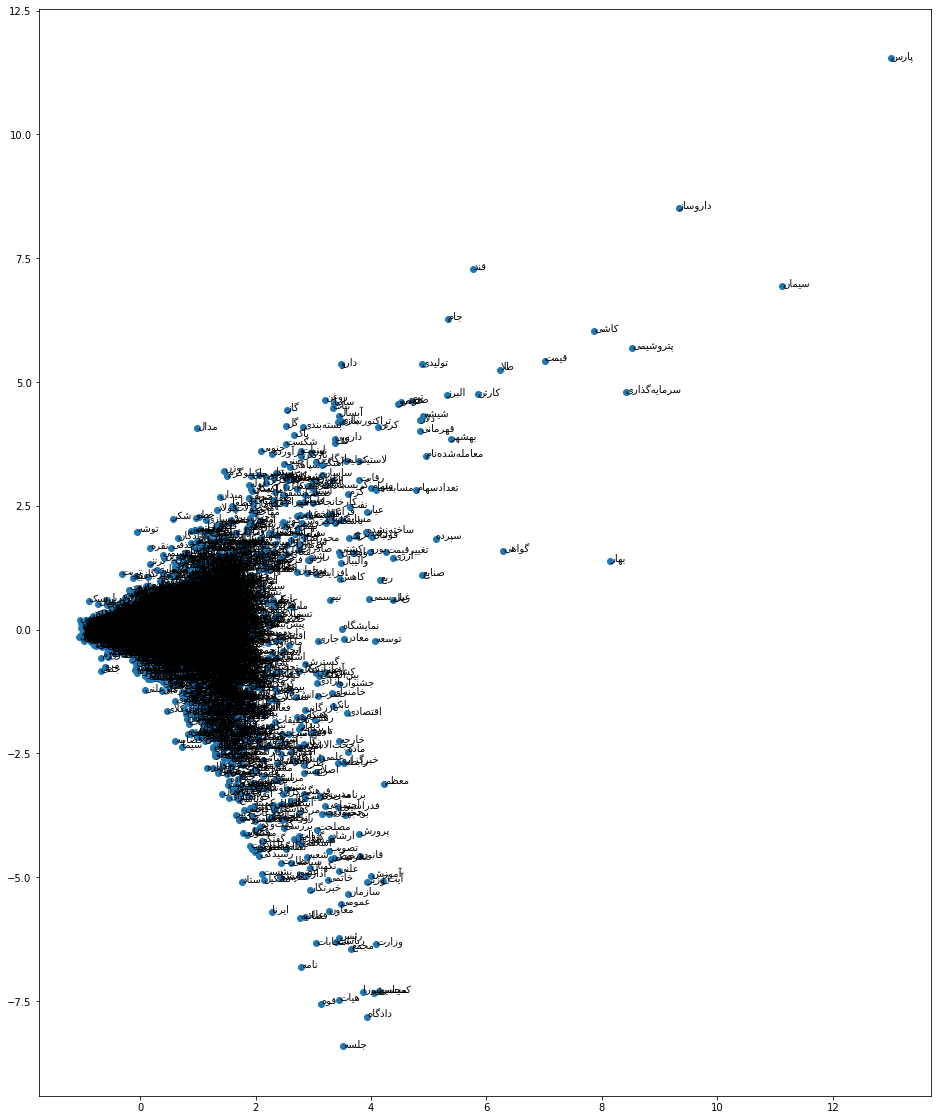

In [68]:
# retrive the vectors from the model
vectors = model_embed.wv[model_embed.wv.index_to_key]


# instantiate the PCA class with 2 dimensions 
# change dimention from 100 to 2 for visualization

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# train the model
result = pca.fit_transform(vectors)

# plot a scatter plot
plt.figure(figsize=(16,20))
plt.scatter(x=result[:,0], y=result[:,1])

# add annotations of the words to the data points
words = list(model_embed.wv.index_to_key)

for i, word in enumerate(words):
  plt.annotate(get_display(reshape(word)), size=10, xy=(result[i, 0], result[i, 1]))